In [1]:
import librosa
import numpy as np
from scipy.signal import get_window
import scipy.fftpack as fft
import matplotlib.pyplot as plt

import scipy.io
from tqdm import tqdm


In [28]:
def wav_to_list(wav_files):
    audio_list = np.zeros(len(wav_files))
    for ind,filename in enumerate(wav_files):
        audio, sample_rate = librosa.load(filename)
        audio_list[ind] = audio
    return audio_list

audio, sample_rate = librosa.load('sa1.wav')

In [29]:
print(audio)
print(sample_rate)
print(len(audio))

[ 2.9922800e-05 -2.2494769e-05 -1.7128708e-06 ... -2.3044803e-04
 -2.0874187e-04  0.0000000e+00]
22050
64493


In [16]:
def all_mfsc(sound_list, s_rate_list, hop_size, timeframes, freq_bins):
    n_sounds = len(sound_list)
    all_results = n_sounds*[None]
    for i in tqdm(range(n_sounds)):
        all_results[i] = one_mfsc(sound_list[i],s_rate_list[i], hop_size, timeframes, freq_bins)
    return all_results

def one_mfsc(sound, s_rate, hop_size, timeframes, freq_bins):
    sound = sound / np.max(np.abs(sound)) #First, we normalize
    frames, fft_len = create_frames(sound, timeframes, s_rate, hop_size)
    window = get_window("hann", fft_len, fftbins=True)
    windowed = frames * window
    windowedT = windowed.T
    fft_sound= np.empty((int(1 + fft_len // 2), windowedT.shape[1]), dtype=np.complex64, order='F')

    for n in range(fft_sound.shape[1]):
        fft_sound[:, n] = fft.fft(windowedT[:, n], axis=0)[:fft_sound.shape[0]]

    fft_soundT = fft_sound.T
    sound_strength = np.square(np.abs(fft_soundT))

    lowf = 0
    highf = s_rate / 2
    
    filt_places, m_freqs = get_filt_places(lowf, highf, freq_bins, fft_len, s_rate)
    filters = make_filters(filt_places, fft_len)
    
    e_val = 2.0 / (m_freqs[2:freq_bins+2] - m_freqs[:freq_bins])
    filters *= e_val[:, np.newaxis]
    
    sound_filt = np.dot(filters, np.transpose(sound_strength))
    sound_log = 10.0 * np.log10(sound_filt)
    
    return sound_log

def create_frames(sound, n_frames, s_rate, hop_size):
    #frame_len = int(s_rate*hop_size/1000)
    frame_len = int(len(sound)/(n_frames-1))
    #FFT_size = -(n_frames-1)*frame_len+len(sound)
    FFT_size = frame_len + (len(sound)/(n_frames-1))#This is the new calculated version
    FFT_size = int(FFT_size/2)*2
    sound = np.pad(sound, int(FFT_size / 2), mode='reflect')
    frames = np.zeros((n_frames, FFT_size))
    #print(40*frame_len+FFT_size)
    #print(len(sound))
    for n in range(n_frames):
        #hahaha = 
        #print(len(hahaha))
        #print(n*frame_len)
        frames[n] = sound[n*frame_len:n*frame_len+FFT_size]
        
    return frames, FFT_size

def f_mel(f): #Converts F to Mel
    return 2595.0 * np.log10(1.0 + f / 700.0)

def mel_f(mel): #Converts Mel to F
    return 700.0 * (10.0**(mel / 2595.0) - 1.0)

def get_filt_places(lowF, highF, n_samples, fft_len, s_rate):
    lowf_mel = f_mel(lowF)
    highf_mel = f_mel(highF)
    
    mel = np.linspace(lowf_mel, highf_mel, num=n_samples+2)
    f = mel_f(mel)
    
    return np.floor((fft_len + 1) / s_rate * f).astype(int), f

def make_filters(filt_places, fft_len):
    filters = np.zeros((len(filt_places)-2,int(fft_len/2+1)))
    
    for n in range(len(filt_places)-2):
        filters[n, filt_places[n] : filt_places[n + 1]] = np.linspace(0, 1, filt_places[n + 1] - filt_places[n])
        filters[n, filt_places[n + 1] : filt_places[n + 2]] = np.linspace(1, 0, filt_places[n + 2] - filt_places[n + 1])
    
    return filters
    
    

#result = one_mfsc(audio, sample_rate, 10)
#print(result.shape)

In [23]:
def convert_tidigit(PATH, sample_rate, hop_size, timeframes, freq_bins):
    mat = scipy.io.loadmat(PATH)
    samples = mat['train_samples']
    audios = [None]*len(samples)
    sample_rates = [sample_rate]*len(samples)
    for index, item in tqdm(enumerate(samples)):
        audios[index] = [value for sublist in item[0] for value in sublist]
        #print(audios[index])
    results = all_mfsc(audios, sample_rates, hop_size, timeframes, freq_bins)
    return results


results = convert_tidigit('TIDIGIT_train.mat', 20000, 20, 41, 40)

2464it [01:39, 24.67it/s]
  0%|▏                                                                                | 4/2464 [00:00<01:12, 33.88it/s]

18270
18278
18816
18816
16380
16396
17178
17202
17724
17740
19866
19890
18816
18816
18816
18816
20958
20966
22008

  1%|▍                                                                               | 13/2464 [00:00<01:10, 34.91it/s]


22040
22302
22310
22554
22578
23898
23922
22008
22040
16926
16934
17724
17740
18522
18546
19320

  1%|▋                                                                               | 23/2464 [00:00<01:01, 39.50it/s]


19352
19320
19352
17178
17202
19614
19622
19866
19890
13944
13976
13440
13440
15582
15590
13146
13170
15288

  1%|█▏                                                                              | 35/2464 [00:00<00:52, 46.60it/s]


15320
13944
13976
16380
16396
14784
14784
19614
19622
17472
17472
19320
19352
18522
18546
16128
16128
17472
17472
14784

  2%|█▎                                                                              | 41/2464 [00:00<00:49, 48.90it/s]


14784
14490
14514
18270
18278
17178
17202
15036
15052
17724
17740
17724
17740
18270
18278
20412
20428
21756
21772
19614
19622


  2%|█▋                                                                              | 52/2464 [00:01<00:50, 47.34it/s]

17976
18008
19866
19890
20160
20160
22302
22310
20958
20966
22302
22310
32256
32256
26586
26610
24696

  3%|██                                                                              | 62/2464 [00:01<00:52, 45.98it/s]


24728
23100
23116
23352
23384
23100
23116
19320
19352
20664
20696
23646
23654
20160
20160
19614
19622
22302

  3%|██▎                                                                             | 73/2464 [00:01<00:50, 47.40it/s]


22310
23100
23116
21756
21772
20958
20966
19614
19622
19320
19352
20664
20696
21210
21234
19320
19352
20664


  3%|██▌                                                                             | 78/2464 [00:01<01:00, 39.37it/s]

20696
26334
26342
20958
20966
27678
27686
23898
23922
21210
21234
20412


  3%|██▋                                                                             | 83/2464 [00:01<00:58, 40.55it/s]

20428
23898
23922
20958
20966
20160
20160
22554
22578
15288
15320
20160
20160
23352
23384
18816
18816
18522
18546
19320

  4%|███                                                                             | 96/2464 [00:02<00:50, 47.10it/s]


19352
18522
18546
16380
16396
24696
24728
19068
19084
17724
17740
20664
20696
17724
17740
20160
20160
23352
23384
22554

  4%|███▎                                                                           | 103/2464 [00:02<00:47, 50.21it/s]


22578
20160
20160
18522
18546
21756
21772
15582
15590
17976
18008
19068
19084
19068
19084
23100
23116
19320
19352
19614
19622


  5%|███▋                                                                           | 116/2464 [00:02<00:45, 51.81it/s]

24696
24728
20412
20428
18522
18546
20412
20428
25242
25266
19866
19890
23898
23922
21756
21772
17724
17740
16926
16934
29568

  5%|████                                                                           | 128/2464 [00:02<00:45, 50.91it/s]


29568
23100
23116
27132
27148
21210
21234
16128
16128
15288
15320
26040
26072
20958
20966
17724
17740
17724

  5%|████▎                                                                          | 134/2464 [00:02<00:48, 48.33it/s]


17740
25242
25266
20412
20428
16380
16396
16926
16934
19614
19622
15582
15590
21756
21772
20160
20160
16926
16934
19614

  6%|████▋                                                                          | 146/2464 [00:03<00:43, 53.46it/s]


19622
19068
19084
21210
21234
20958
20966
20412
20428
17976
18008
20412
20428
19320
19352
16926
16934
22008
22040
21504
21504
16380
16396


  6%|█████                                                                          | 159/2464 [00:03<00:41, 55.27it/s]

20664
20696
17724
17740
19866
19890
17976
18008
18270
18278
15036
15052
18270
18278
16632
16664
18522
18546
20160
20160
20412

  7%|█████▌                                                                         | 173/2464 [00:03<00:39, 58.47it/s]


20428
20412
20428
21504
21504
20958
20966
20160
20160
21504
21504
19068
19084
17472
17472
16380
16396
18522
18546
18522
18546
17472
17472


  7%|█████▊                                                                         | 180/2464 [00:03<00:39, 58.49it/s]

17472
17472
19614
19622
21756
21772
17724
17740
18522
18546
17976
18008
16926
16934
18816
18816
21504
21504
17724
17740
19614
19622
20958

  8%|██████▏                                                                        | 194/2464 [00:03<00:37, 60.96it/s]


20966
18522
18546
25536
25536
24192
24192
20664
20696
20412
20428
16632
16664
16926
16934
18522
18546
19320
19352
16380
16396
16632
16664
20160

  8%|██████▍                                                                        | 201/2464 [00:03<00:37, 60.82it/s]


20160
18522
18546
23100
23116
24444
24460
23100
23116
18522
18546
20664
20696
20160
20160
21756
21772
24192
24192
25242
25266


  9%|██████▊                                                                        | 214/2464 [00:04<00:43, 52.32it/s]

22848
22848
28476
28492
25242
25266
22302
22310
22008
22040
21756
21772
19866
19890
23100
23116
25536
25536
17976

  9%|███████▏                                                                       | 226/2464 [00:04<00:40, 54.94it/s]


18008
17472
17472
22554
22578
22008
22040
20958
20966
19866
19890
15582
15590
15288
15320
16632
16664
19320
19352
24444
24460
18270

  9%|███████▍                                                                       | 232/2464 [00:04<00:45, 48.92it/s]


18278
21756
21772
19614
19622
27678
27686
21756
21772
20160
20160
18816
18816
18522
18546
21756
21772
19320

 10%|███████▊                                                                       | 244/2464 [00:04<00:42, 51.76it/s]


19352
19614
19622
15834
15858
26040
26072
22008
22040
19614
19622
24990
24998
21210
21234
16632
16664
16926
16934
17724

 10%|████████                                                                       | 251/2464 [00:04<00:40, 54.48it/s]


17740
18522
18546
16926
16934
17724
17740
17178
17202
17178
17202
22302
22310
20160
20160
19614
19622
20160
20160
17724
17740
14490

 11%|████████▍                                                                      | 264/2464 [00:05<00:39, 56.34it/s]


14514
18270
18278
19068
19084
16926
16934
19068
19084
20412
20428
19614
19622
20664
20696
22008
22040
16632
16664
23898

 11%|████████▋                                                                      | 270/2464 [00:05<00:46, 47.07it/s]


23922
20958
20966
24990
24998
24990
24998
19614
19622
29820
29836
27132
27148
30366


 11%|█████████                                                                      | 281/2464 [00:05<00:47, 46.37it/s]

30374
24444
24460
25788
25804
25242
25266
20664
20696
17472
17472
18816
18816
23352
23384
25788

 12%|█████████▏                                                                     | 287/2464 [00:05<00:44, 49.20it/s]


25804
16128
16128
20664
20696
20160
20160
21210
21234
21756
21772
37338
37362
35994
36018


 12%|█████████▍                                                                     | 293/2464 [00:05<00:50, 42.94it/s]

15834
15858
16632
16664
23100
23116
30072
30104
27678
27686
22848
22848
24696
24728
24696
24728


 12%|█████████▊                                                                     | 305/2464 [00:06<00:48, 44.70it/s]

22554
22578
32256
32256
20160
20160
17724
17740
18270
18278
20412
20428
21504
21504
20958
20966
23646
23654


 13%|██████████▏                                                                    | 317/2464 [00:06<00:44, 48.52it/s]

24192
24192
23100
23116
17472
17472
16926
16934
15288
15320
19068
19084
16632
16664
17724
17740
16926
16934
19068
19084
18816
18816
20958
20966
20160

 13%|██████████▋                                                                    | 332/2464 [00:06<00:37, 57.19it/s]


20160
17178
17202
16926
16934
16926
16934
16926
16934
19320
19352
19320
19352
15288
15320
15582
15590
21210
21234
16926
16934
18522
18546
21756
21772
21210
21234
19866

 14%|██████████▊                                                                    | 339/2464 [00:06<00:35, 59.30it/s]


19890
21504
21504
23100
23116
25242
25266
19068
19084
18816
18816
25536
25536
24192
24192
26334
26342
20958
20966
24696
24728
21504
21504
20412

 14%|███████████▎                                                                   | 353/2464 [00:06<00:33, 62.48it/s]


20428
21504
21504
20160
20160
19320
19352
24192
24192
24192
24192
28476
28492
20958
20966
17178
17202
15834
15858
15582
15590
20664
20696
22008

 15%|███████████▊                                                                   | 367/2464 [00:07<00:35, 58.54it/s]


22040
16926
16934
21756
21772
22848
22848
22848
22848
24696
24728
23100
23116
20958
20966
23898
23922
20160
20160
14784
14784


 15%|███████████▉                                                                   | 373/2464 [00:07<00:39, 53.50it/s]

24192
24192
19614
19622
19614
19622
21504
21504
19320
19352
27132
27148
20958
20966
20958
20966
20412

 16%|████████████▍                                                                  | 386/2464 [00:07<00:37, 54.84it/s]


20428
22554
22578
21210
21234
22302
22310
24696
24728
23352
23384
25788
25804
27132
27148
26586
26610
27132
27148
21756
21772
26040
26072
15582

 16%|████████████▌                                                                  | 393/2464 [00:07<00:35, 58.36it/s]


15590
19320
19352
26334
26342
24192
24192
17976
18008
18816
18816
21504
21504
23646
23654
16926
16934
19614
19622
17724


 16%|█████████████                                                                  | 406/2464 [00:07<00:36, 56.31it/s]

17740
17724
17740
18522
18546
19320
19352
21756
21772
20958
20966
19068
19084
17724
17740
22554
22578
24444
24460
18816
18816
21504
21504
19866
19890
19320

 17%|█████████████▍                                                                 | 421/2464 [00:08<00:32, 62.42it/s]


19352
18270
18278
17472
17472
15582
15590
17178
17202
20664
20696
19614
19622
24696
24728
24696
24728
18270
18278
19068
19084
21504
21504
16926
16934
21756

 17%|█████████████▋                                                                 | 428/2464 [00:08<00:34, 59.50it/s]


21772
25242
25266
22848
22848
18522
18546
20958
20966
22008
22040
17976
18008
19068
19084
21756
21772
17178

 18%|██████████████▏                                                                | 441/2464 [00:08<00:36, 55.85it/s]


17202
18522
18546
23646
23654
19614
19622
17976
18008
22554
22578
22008
22040
18270
18278
15834
15858
15288
15320
16380
16396
15582

 18%|██████████████▎                                                                | 448/2464 [00:08<00:34, 58.84it/s]


15590
19866
19890
20958
20966
16926
16934
21210
21234
19614
19622
23646
23654
24990
24998
17976
18008
26880
26880


 19%|██████████████▊                                                                | 463/2464 [00:08<00:31, 62.57it/s]

17472
17472
20412
20428
16128
16128
15834
15858
18522
18546
15582
15590
18816
18816
17976
18008
21504
21504
22008
22040
21504
21504
21210
21234
21504
21504
21210
21234
21210
21234
22554
22578
27132

 19%|███████████████▎                                                               | 479/2464 [00:08<00:29, 66.46it/s]


27148
22008
22040
24444
24460
24990
24998
22554
22578
22008
22040
15834
15858
19068
19084
22302
22310
22554
22578
21210
21234
18522

 20%|███████████████▌                                                               | 486/2464 [00:09<00:31, 62.11it/s]


18546
24990
24998
21210
21234
19866
19890
16632
16664
20412
20428
19614
19622
23646
23654
17472
17472
20958
20966
17724

 20%|███████████████▉                                                               | 499/2464 [00:09<00:34, 56.91it/s]


17740
26040
26072
19320
19352
23646
23654
23898
23922
18522
18546
18816
18816
17724
17740
16632
16664
22554
22578
19068
19084
21210
21234

 21%|████████████████▍                                                              | 513/2464 [00:09<00:32, 60.54it/s]


19320
19352
24192
24192
19614
19622
16380
16396
15834
15858
14238
14246
13440
13440
18816
18816
14490
14514
12894
12902
13944
13976
16380
16396
15288

 21%|████████████████▋                                                              | 522/2464 [00:09<00:29, 66.28it/s]


15320
20664
20696
22848
22848
17976
18008
16380
16396
15582
15590
12348
12364
15288
15320
14238
14246
13692
13708
12894
12902
19068
19084
17724
17740
17472
17472
18816
18816


 22%|█████████████████▏                                                             | 538/2464 [00:09<00:28, 66.75it/s]

17724
17740
15582
15590
16128
16128
18522
18546
19614
19622
18270
18278
23646
23654
18816
18816
20160
20160
23352
23384
17976
18008
24444
24460
20664

 22%|█████████████████▋                                                             | 553/2464 [00:10<00:28, 67.43it/s]


20696
18816
18816
16128
16128
17178
17202
18522
18546
17472
17472
17724
17740
19068
19084
24192
24192
20664
20696
21210
21234
17472
17472
17724
17740
17724
17740


 23%|█████████████████▉                                                             | 560/2464 [00:10<00:30, 62.76it/s]

23898
23922
21210
21234
19320
19352
26586
26610
23100
23116
26040
26072
22554
22578
23352
23384
18522
18546
17472
17472
22848
22848
19320

 23%|██████████████████▍                                                            | 575/2464 [00:10<00:30, 61.79it/s]


19352
21210
21234
20664
20696
27384
27416
25788
25804
25536
25536
17976
18008
17178
17202
19320
19352
22554
22578
18270
18278
19320
19352
20958

 24%|██████████████████▋                                                            | 582/2464 [00:10<00:32, 58.36it/s]


20966
20160
20160
25242
25266
19614
19622
20664
20696
21504
21504
18522
18546
21504
21504
21210
21234
19866

 24%|███████████████████                                                            | 596/2464 [00:10<00:30, 61.07it/s]


19890
26880
26880
15288
15320
22008
22040
26586
26610
23352
23384
19866
19890
16380
16396
15582
15590
15582
15590
23100
23116
17178
17202
24696

 25%|███████████████████▋                                                           | 613/2464 [00:11<00:27, 68.50it/s]


24728
17472
17472
23352
23384
18816
18816
23100
23116
24990
24998
21756
21772
18270
18278
21504
21504
19068
19084
17472
17472
20160
20160
18816
18816
19866
19890
18270
18278
19320

 25%|███████████████████▉                                                           | 621/2464 [00:11<00:30, 61.00it/s]


19352
30366
30374
22848
22848
23352
23384
21210
21234
25788
25804
26334
26342
21756
21772
24444
24460
26334

 26%|████████████████████▎                                                          | 635/2464 [00:11<00:30, 60.12it/s]


26342
27930
27954
27930
27954
26334
26342
21756
21772
23352
23384
24192
24192
19320
19352
23352
23384
23352
23384
23100
23116
21504

 26%|████████████████████▌                                                          | 642/2464 [00:11<00:31, 57.48it/s]


21504
27132
27148
24990
24998
16632
16664
23100
23116
20958
20966
19614
19622
19614
19622
18522
18546
20664
20696
21210

 27%|████████████████████▉                                                          | 654/2464 [00:11<00:31, 58.22it/s]


21234
21504
21504
18270
18278
21504
21504
24192
24192
20958
20966
22554
22578
16632
16664
16632
16664
18816
18816
24696
24728
20958
20966
19068

 27%|█████████████████████▍                                                         | 670/2464 [00:12<00:27, 65.36it/s]


19084
19320
19352
20160
20160
16632
16664
29274
29298
18522
18546
20412
20428
17724
17740
20412
20428
17976
18008
17724
17740
17472
17472
21210
21234
21756
21772
23100

 28%|█████████████████████▊                                                         | 679/2464 [00:12<00:25, 70.34it/s]


23116
19320
19352
27132
27148
17472
17472
16632
16664
20664
20696
22848
22848
20664
20696
15834
15858
21504
21504
19866
19890
15288
15320
16128
16128
13944
13976
13146
13170
17724
17740
15288

 28%|██████████████████████▎                                                        | 697/2464 [00:12<00:23, 76.10it/s]


15320
16128
16128
15582
15590
16128
16128
14784
14784
18270
18278
20412
20428
16128
16128
14784
14784
14784
14784
14784
14784
15036
15052
17724
17740
14238
14246
15036
15052
15036

 29%|██████████████████████▊                                                        | 713/2464 [00:12<00:23, 75.79it/s]


15052
16632
16664
16380
16396
19614
19622
18522
18546
19866
19890
16632
16664
18270
18278
22008
22040
17472
17472
17472
17472
17472
17472
22554
22578
24696

 30%|███████████████████████▎                                                       | 729/2464 [00:12<00:23, 73.87it/s]


24728
20412
20428
18270
18278
21504
21504
22008
22040
17724
17740
16926
16934
19068
19084
15036
15052
22848
22848
22008
22040
16632
16664
23646
23654
15834
15858
15582
15590
17472

 30%|███████████████████████▋                                                       | 737/2464 [00:12<00:25, 67.66it/s]


17472
17724
17740
26040
26072
24696
24728
19866
19890
23898
23922
27384
27416
29274
29298
19068
19084
33054

 30%|███████████████████████▊                                                       | 744/2464 [00:13<00:30, 56.13it/s]


33062
19320
19352
19320
19352
22554
22578
20412
20428
24696
24728
15582
15590
21756
21772
23100
23116
16926
16934
16926
16934
14238

 31%|████████████████████████▎                                                      | 759/2464 [00:13<00:26, 63.45it/s]


14246
16926
16934
16632
16664
17724
17740
16926
16934
16926
16934
19068
19084
20664
20696
22554
22578
21504
21504
19614
19622
20412
20428
17976

 31%|████████████████████████▊                                                      | 773/2464 [00:13<00:27, 60.91it/s]


18008
17976
18008
19866
19890
19866
19890
17724
17740
16926
16934
20160
20160
19614
19622
20160
20160
20958
20966
16380
16396


 32%|█████████████████████████                                                      | 780/2464 [00:13<00:26, 63.18it/s]

18270
18278
20412
20428
22008
22040
17724
17740
17472
17472
19320
19352
24192
24192
23898
23922
22008
22040
20412
20428
33600
33600
16926
16934
21504
21504
20412

 32%|█████████████████████████▍                                                     | 794/2464 [00:13<00:30, 54.94it/s]


20428
19866
19890
18522
18546
17976
18008
22848
22848
25242
25266
20958
20966
20958
20966


 33%|█████████████████████████▋                                                     | 802/2464 [00:14<00:28, 59.17it/s]

18522
18546
17472
17472
19614
19622
17472
17472
19866
19890
18816
18816
24192
24192
19068
19084
24990
24998
30072
30104
22008
22040
19866
19890
20412
20428
19614

 33%|██████████████████████████▏                                                    | 816/2464 [00:14<00:28, 58.82it/s]


19622
24444
24460
23646
23654
17178
17202
20958
20966
22848
22848
27930
27954
15288
15320
17724
17740
15582
15590
15582
15590
15834
15858
15582

 34%|██████████████████████████▍                                                    | 826/2464 [00:14<00:24, 65.65it/s]


15590
15834
15858
16380
16396
18522
18546
17472
17472
24444
24460
21504
21504
18522
18546
21210
21234
16632
16664
20412
20428
17178
17202
18270
18278
15288
15320


 34%|██████████████████████████▉                                                    | 840/2464 [00:14<00:24, 65.03it/s]

16128
16128
18522
18546
19068
19084
16128
16128
17976
18008
17178
17202
17178
17202
19866
19890
17976
18008
17472
17472
21210
21234
17724
17740
19068

 35%|███████████████████████████▍                                                   | 855/2464 [00:14<00:24, 66.97it/s]


19084
20412
20428
24696
24728
19320
19352
21504
21504
16926
16934
16380
16396
17724
17740
20958
20966
16632
16664
20664
20696
19068
19084
23352
23384
16926

 35%|███████████████████████████▋                                                   | 862/2464 [00:14<00:25, 61.89it/s]


16934
19320
19352
28224
28224
20958
20966
22554
22578
19068
19084
21210
21234
19320
19352
20958
20966
22554
22578
26040

 36%|████████████████████████████                                                   | 875/2464 [00:15<00:27, 57.68it/s]


26072
24696
24728
22008
22040
19068
19084
19068
19084
14784
14784
30072
30104
22008
22040
17724
17740
20160
20160
23898
23922
21504

 36%|████████████████████████████▌                                                  | 889/2464 [00:15<00:25, 61.08it/s]


21504
17472
17472
16380
16396
18816
18816
16632
16664
17976
18008
17976
18008
17178
17202
17976
18008
19614
19622
18522
18546
21756
21772
22302
22310
23352
23384
20160
20160
20160

 37%|█████████████████████████████                                                  | 907/2464 [00:15<00:21, 71.76it/s]


20160
16926
16934
19068
19084
17472
17472
16380
16396
18816
18816
20160
20160
19320
19352
21504
21504
20412
20428
23898
23922
19866
19890
21210
21234
21504
21504
23646
23654
21504

 37%|█████████████████████████████▎                                                 | 915/2464 [00:15<00:25, 60.68it/s]


21504
26586
26610
26586
26610
25536
25536
25788
25804
24444
24460
21504
21504
22008
22040
22554
22578
24192
24192
24444
24460
19614

 38%|█████████████████████████████▊                                                 | 930/2464 [00:15<00:22, 66.73it/s]


19622
19866
19890
24444
24460
21504
21504
21210
21234
16926
16934
21210
21234
20664
20696
17724
17740
20664
20696
19068
19084
19614
19622
23100
23116
22302

 38%|██████████████████████████████                                                 | 937/2464 [00:16<00:24, 62.99it/s]


22310
21756
21772
25242
25266
21756
21772
22008
22040
22848
22848
26880
26880
17472
17472
19068
19084
19614
19622
15834
15858
23898
23922


 39%|██████████████████████████████▌                                                | 952/2464 [00:16<00:23, 63.15it/s]

30366
30374
21504
21504
21756
21772
20958
20966
18522
18546
19068
19084
19068
19084
20160
20160
23352
23384
21210
21234
23352
23384
21504
21504
27132

 39%|██████████████████████████████▉                                                | 966/2464 [00:16<00:24, 61.47it/s]


27148
20958
20966
22554
22578
19614
19622
18522
18546
22554
22578
22008
22040
20664
20696
21756
21772
27132
27148
20664
20696
24444

 39%|███████████████████████████████▏                                               | 973/2464 [00:16<00:23, 63.66it/s]


24460
17724
17740
22848
22848
21504
21504
24192
24192
22554
22578
29022
29030
23352
23384
24192
24192
19320

 40%|███████████████████████████████▌                                               | 986/2464 [00:16<00:26, 54.87it/s]


19352
32760
32792
35742
35750
31164
31180
23898
23922
21210
21234
22848
22848
18522
18546
19068
19084
23100
23116
20958
20966
19320

 40%|███████████████████████████████▊                                               | 994/2464 [00:17<00:24, 59.43it/s]


19352
22302
22310
16632
16664
16926
16934
17976
18008
20160
20160
19320
19352
20412
20428
20958
20966
20958
20966
20412
20428
24444
24460
22848

 41%|███████████████████████████████▉                                              | 1007/2464 [00:17<00:27, 52.35it/s]


22848
23898
23922
20412
20428
20412
20428
17178
17202
17976
18008
20958
20966
21210
21234
16926
16934
17178

 41%|████████████████████████████████                                              | 1014/2464 [00:17<00:25, 56.37it/s]


17202
20412
20428
22008
22040
15582
15590
19866
19890
14784
14784
17976
18008
19320
19352
21210
21234
17472
17472
16632
16664
16632
16664
19068
19084
20958
20966


 42%|████████████████████████████████▌                                             | 1030/2464 [00:17<00:25, 56.66it/s]

19866
19890
20412
20428
22008
22040
14238
14246
13692
13708
23646
23654
21210
21234
15834
15858
15834
15858
23646
23654


 42%|█████████████████████████████████                                             | 1045/2464 [00:17<00:22, 63.27it/s]

17976
18008
16128
16128
16632
16664
16128
16128
17472
17472
18816
18816
17724
17740
17976
18008
19320
19352
19866
19890
19866
19890
22554
22578
29274
29298
18522
18546
19068
19084
15288

 43%|█████████████████████████████████▎                                            | 1053/2464 [00:18<00:21, 65.11it/s]


15320
15582
15590
19068
19084
19068
19084
16128
16128
15582
15590
21756
21772
20664
20696
25788
25804
22302
22310
25536
25536
26040
26072


 43%|█████████████████████████████████▊                                            | 1067/2464 [00:18<00:23, 60.34it/s]

24696
24728
22848
22848
17472
17472
25242
25266
21504
21504
19068
19084
27132
27148
32508
32524
26880
26880
21504
21504
19068
19084
18270

 44%|██████████████████████████████████▏                                           | 1081/2464 [00:18<00:21, 63.14it/s]


18278
24192
24192
21504
21504
18270
18278
18522
18546
29568
29568
22008
22040
19614
19622
17724
17740
16632
16664
19068
19084
18270
18278
17472

 44%|██████████████████████████████████▌                                           | 1091/2464 [00:18<00:19, 69.70it/s]


17472
18816
18816
18270
18278
22008
22040
20160
20160
22302
22310
20664
20696
19866
19890
19614
19622
17178
17202
19068
19084
19068
19084
21210
21234
16380

 45%|██████████████████████████████████▊                                           | 1099/2464 [00:18<00:21, 62.70it/s]


16396
17178
17202
22008
22040
22008
22040
23898
23922
16926
16934
16128
16128
25788
25804
19614
19622
17724
17740


 45%|███████████████████████████████████▎                                          | 1114/2464 [00:18<00:21, 64.00it/s]

17472
17472
18816
18816
18270
18278
17976
18008
20412
20428
20412
20428
19614
19622
18816
18816
17178
17202
21210
21234
19614
19622
23646
23654
16128

 46%|███████████████████████████████████▊                                          | 1130/2464 [00:19<00:20, 64.35it/s]


16128
16926
16934
21210
21234
26334
26342
19068
19084
19320
19352
16380
16396
18816
18816
20160
20160
19068
19084
16632
16664
19320
19352
20160
20160
21756
21772
23352

 46%|████████████████████████████████████▏                                         | 1144/2464 [00:19<00:19, 66.24it/s]


23384
22848
22848
21504
21504
20160
20160
13944
13976
17178
17202
20160
20160
17472
17472
19614
19622
18522
18546
21756
21772
18522
18546
17724
17740
23646

 47%|████████████████████████████████████▍                                         | 1151/2464 [00:19<00:21, 61.10it/s]


23654
20160
20160
22302
22310
19614
19622
23100
23116
22554
22578
22008
22040
23898
23922
25536
25536
26040
26072
28728

 47%|████████████████████████████████████▉                                         | 1165/2464 [00:19<00:22, 56.66it/s]


28760
22554
22578
22554
22578
17976
18008
20412
20428
20958
20966
20412
20428
17724
17740
22554
22578
25788
25804
21504
21504
20412

 48%|█████████████████████████████████████                                         | 1172/2464 [00:19<00:22, 58.40it/s]


20428
20412
20428
15288
15320
17976
18008
20958
20966
22302
22310
20664
20696
17472
17472
22554
22578
17976
18008
20958
20966


 48%|█████████████████████████████████████▌                                        | 1185/2464 [00:20<00:22, 56.24it/s]

23898
23922
22302
22310
20160
20160
17472
17472
16632
16664
20412
20428
20160
20160
19614
19622
17724
17740
22554
22578
22554
22578
17472

 48%|█████████████████████████████████████▋                                        | 1192/2464 [00:20<00:21, 58.73it/s]


17472
17724
17740
16632
16664
16128
16128
16632
16664
17472
17472
20664
20696
19068
19084
20958
20966
20412
20428
22554
22578


 49%|██████████████████████████████████████▏                                       | 1205/2464 [00:20<00:22, 57.18it/s]

23352
23384
19320
19352
19320
19352
19866
19890
19068
19084
19614
19622
15834
15858
17976
18008
16926
16934
22848
22848
20664
20696
15834
15858
15834
15858
14784
14784


 50%|██████████████████████████████████████▋                                       | 1222/2464 [00:20<00:19, 64.40it/s]

19614
19622
15036
15052
16632
16664
20958
20966
18270
18278
17472
17472
18816
18816
20412
20428
23646
23654
21756
21772
19320
19352
17724
17740
15036
15052
17178

 50%|██████████████████████████████████████▉                                       | 1231/2464 [00:20<00:17, 69.75it/s]


17202
18522
18546
18816
18816
15834
15858
17472
17472
24990
24998
17724
17740
17976
18008
17472
17472
17724
17740
18522
18546
18522
18546
19320
19352


 51%|███████████████████████████████████████▍                                      | 1246/2464 [00:21<00:19, 62.58it/s]

17472
17472
19614
19622
17472
17472
23100
23116
23100
23116
20958
20966
19068
19084
16380
16396
16380
16396
18522
18546
18816
18816
16926
16934
17178
17202
25242

 51%|███████████████████████████████████████▉                                      | 1260/2464 [00:21<00:20, 59.53it/s]


25266
23352
23384
16632
16664
17178
17202
16926
16934
17472
17472
17472
17472
18270
18278
19068
19084
19614
19622

 51%|████████████████████████████████████████                                      | 1267/2464 [00:21<00:20, 57.13it/s]


18816
18816
20664
20696
28224
28224
22848
22848
19320
19352
19320
19352
18522
18546
19068
19084
19614
19622
21504
21504

 52%|████████████████████████████████████████▍                                     | 1279/2464 [00:21<00:22, 51.80it/s]


17724
17740
22848
22848
20958
20966
24192
24192
17724
17740
23646
23654
17472
17472
17472
17472
22554

 52%|████████████████████████████████████████▋                                     | 1285/2464 [00:21<00:23, 49.85it/s]


22578
23898
23922
25536
25536
20664
20696
27132
27148
23646
23654
24696
24728
27678

 52%|████████████████████████████████████████▊                                     | 1291/2464 [00:22<00:27, 42.01it/s]


27686
21756
21772
23898
23922
22848
22848
22302
22310
22848
22848
23646
23654
19320

 53%|█████████████████████████████████████████▏                                    | 1303/2464 [00:22<00:24, 47.54it/s]


19352
17724
17740
27132
27148
26040
26072
21210
21234
18522
18546
22302
22310
18270
18278
21756
21772
20664
20696
17976
18008
17724

 53%|█████████████████████████████████████████▍                                    | 1309/2464 [00:22<00:23, 49.23it/s]


17740
18522
18546
18270
18278
22554
22578
21756
21772
20664
20696
21210
21234
17976
18008
18816
18816
19866
19890
19320
19352


 54%|█████████████████████████████████████████▊                                    | 1322/2464 [00:22<00:22, 50.16it/s]

17724
17740
22302
22310
23646
23654
24696
24728
20412
20428
17178
17202
21756
21772
15834
15858
18522
18546
24192
24192
18270
18278


 54%|██████████████████████████████████████████                                    | 1328/2464 [00:22<00:22, 51.05it/s]

19614
19622
20958
20966
25788
25804
27678
27686
26880
26880
19068

 54%|██████████████████████████████████████████▍                                   | 1341/2464 [00:23<00:23, 47.81it/s]


19084
21210
21234
23898
23922
16128
16128
17976
18008
18522
18546
16128
16128
19866
19890
21756
21772
21756
21772
24444
24460
25788

 55%|██████████████████████████████████████████▋                                   | 1347/2464 [00:23<00:25, 44.26it/s]


25804
25242
25266
19614
19622
22302
22310
21756
21772
26040
26072
28224
28224
26880
26880
31416
31448


 55%|███████████████████████████████████████████                                   | 1360/2464 [00:23<00:21, 50.80it/s]

27132
27148
26334
26342
25536
25536
22848
22848
23352
23384
24990
24998
23352
23384
21504
21504
18816
18816
19614
19622
23352
23384
27930

 56%|███████████████████████████████████████████▍                                  | 1372/2464 [00:23<00:22, 48.68it/s]


27954
19866
19890
26040
26072
20664
20696
22302
22310
22848
22848
21504
21504
23646
23654
20160
20160


 56%|███████████████████████████████████████████▌                                  | 1378/2464 [00:23<00:24, 43.58it/s]

22848
22848
23898
23922
25536
25536
27384
27416
25242
25266
23646
23654
22554
22578
24192

 56%|███████████████████████████████████████████▊                                  | 1384/2464 [00:23<00:23, 46.33it/s]


24192
27384
27416
24990
24998
22008
22040
20412
20428
28224
28224
27132
27148
21210
21234
17724
17740
18270
18278
17178
17202


 57%|████████████████████████████████████████████▏                                 | 1396/2464 [00:24<00:21, 50.19it/s]

18816
18816
17976
18008
17178
17202
17976
18008
18270
18278
17178
17202
24192
24192
27132
27148
19866
19890
20664
20696
19614

 57%|████████████████████████████████████████████▋                                 | 1410/2464 [00:24<00:19, 53.91it/s]


19622
16632
16664
19068
19084
19320
19352
16926
16934
20412
20428
21756
21772
22302
22310
19866
19890
19320
19352
22554
22578
22302

 58%|█████████████████████████████████████████████                                 | 1422/2464 [00:24<00:18, 56.20it/s]


22310
38136
38168
19866
19890
26040
26072
25536
25536
27930
27954
32760
32792
22848
22848
22008
22040
26586
26610
20664
20696
18270

 58%|█████████████████████████████████████████████▏                                | 1428/2464 [00:24<00:19, 53.57it/s]


18278
23898
23922
21504
21504
22302
22310
18270
18278
23646
23654
27930
27954
21210
21234
21756
21772
18522
18546
21210
21234
21504

 58%|█████████████████████████████████████████████▌                                | 1441/2464 [00:25<00:18, 54.81it/s]


21504
27384
27416
22848
22848
23898
23922
24990
24998
25536
25536
26040
26072
29568
29568
29274
29298
23646
23654
20958

 59%|█████████████████████████████████████████████▉                                | 1453/2464 [00:25<00:18, 54.45it/s]


20966
22848
22848
24444
24460
18270
18278
17976
18008
20412
20428
26040
26072
23100
23116
37338
37362
40824
40856
20160

 59%|██████████████████████████████████████████████▏                               | 1459/2464 [00:25<00:18, 55.35it/s]


20160
18522
18546
14784
14784
19614
19622
20412
20428
16926
16934
17472
17472
25536
25536
24192
24192
26586
26610
22554
22578
21504
21504
22302

 60%|██████████████████████████████████████████████▌                               | 1472/2464 [00:25<00:17, 57.14it/s]


22310
21504
21504
15288
15320
22848
22848
22554
22578
16128
16128
19614
19622
24990
24998
17976
18008
22848
22848
20412
20428
16632

 60%|███████████████████████████████████████████████                               | 1485/2464 [00:25<00:18, 53.63it/s]


16664
17178
17202
17472
17472
22008
22040
22302
22310
19866
19890
21504
21504
17724
17740
23898
23922
22554
22578
21756

 61%|███████████████████████████████████████████████▏                              | 1492/2464 [00:25<00:17, 55.58it/s]


21772
23352
23384
22302
22310
36288
36288
20412
20428
22554
22578
20958
20966
23100
23116
24990
24998
19614
19622
18522

 61%|███████████████████████████████████████████████▌                              | 1504/2464 [00:26<00:17, 55.94it/s]


18546
19068
19084
17724
17740
18270
18278
17178
17202
18270
18278
17976
18008
20412
20428
17472
17472
18816
18816
20412
20428
21210

 62%|████████████████████████████████████████████████                              | 1517/2464 [00:26<00:16, 58.06it/s]


21234
22302
22310
19068
19084
16128
16128
15582
15590
19068
19084
18816
18816
19320
19352
17178
17202
24696
24728
24696
24728
17976
18008
15834

 62%|████████████████████████████████████████████████▎                             | 1525/2464 [00:26<00:15, 62.23it/s]


15858
17472
17472
16632
16664
17472
17472
16926
16934
15582
15590
14490
14514
17976
18008
17178
17202
24444
24460
21756
21772
23352

 62%|████████████████████████████████████████████████▋                             | 1539/2464 [00:26<00:16, 56.50it/s]


23384
23898
23922
22008
22040
22848
22848
20160
20160
20958
20966
14784
14784
17976
18008
19320
19352
20412
20428
18816

 63%|████████████████████████████████████████████████▉                             | 1546/2464 [00:26<00:15, 58.02it/s]


18816
19320
19352
15288
15320
20958
20966
17472
17472
20412
20428
24990
24998
22554
22578
17472
17472
17472
17472
23352
23384
26040

 63%|█████████████████████████████████████████████████▎                            | 1559/2464 [00:27<00:15, 59.89it/s]


26072
22302
22310
21756
21772
22554
22578
17976
18008
25788
25804
21504
21504
16926
16934
16380
16396
19320
19352
21210
21234
14784
14784
18522
18546


 64%|█████████████████████████████████████████████████▌                            | 1566/2464 [00:27<00:17, 51.24it/s]

27678
27686
17178
17202
19866
19890
17472
17472
17976
18008
16632
16664
15582
15590
19614

 64%|█████████████████████████████████████████████████▉                            | 1578/2464 [00:27<00:17, 51.68it/s]


19622
19866
19890
19614
19622
22008
22040
17724
17740
14490
14514
13440
13440
16128
16128
17724
17740
15582


 65%|██████████████████████████████████████████████████▍                           | 1592/2464 [00:27<00:14, 58.60it/s]

15590
14238
14246
20664
20696
20664
20696
20412
20428
20160
20160
18270
18278
18522
18546
19614
19622
19866
19890
21756
21772
24192
24192
20160
20160
20664

 65%|██████████████████████████████████████████████████▌                           | 1599/2464 [00:27<00:14, 60.40it/s]


20696
23100
23116
22554
22578
21756
21772
21504
21504
20160
20160
22848
22848
20412
20428
21210
21234
19068
19084
19320
19352
24444
24460
22554

 65%|███████████████████████████████████████████████████                           | 1613/2464 [00:28<00:14, 59.27it/s]


22578
20412
20428
16632
16664
15834
15858
16632
16664
21210
21234
17472
17472
17724
17740
16380
16396
23100
23116
17724


 66%|███████████████████████████████████████████████████▎                          | 1620/2464 [00:28<00:14, 58.17it/s]

17740
21504
21504
22302
22310
22008
22040
18270
18278
17976
18008
23352
23384
22848
22848
20664
20696
16926
16934
19866

 66%|███████████████████████████████████████████████████▋                          | 1633/2464 [00:28<00:14, 57.61it/s]


19890
18816
18816
19320
19352
19320
19352
18816
18816
18522
18546
18816
18816
18522
18546
19320
19352
21756
21772
19866
19890
23352
23384
20160


 67%|████████████████████████████████████████████████████▏                         | 1647/2464 [00:28<00:13, 59.33it/s]

20160
29274
29298
24696
24728
22302
22310
24192
24192
18522
18546
20412
20428
20412
20428
20160
20160
17976
18008
18270
18278
26334
26342
20958

 67%|████████████████████████████████████████████████████▌                         | 1660/2464 [00:28<00:13, 60.99it/s]


20966
20412
20428
20412
20428
24696
24728
18270
18278
19866
19890
24696
24728
22554
22578
20412
20428
20412
20428
24990
24998


 68%|████████████████████████████████████████████████████▊                         | 1667/2464 [00:28<00:13, 58.14it/s]

25788
25804
27930
27954
21504
21504
22848
22848
24990
24998
15834
15858
19068
19084
17724
17740
20664
20696
20958
20966
28476

 68%|█████████████████████████████████████████████████████▏                        | 1679/2464 [00:29<00:14, 55.75it/s]


28492
20160
20160
20160
20160
16632
16664
19320
19352
16128
16128
23646
23654
21210
21234
21756
21772
22302
22310
25788
25804
23352

 68%|█████████████████████████████████████████████████████▎                        | 1685/2464 [00:29<00:16, 48.30it/s]


23384
25788
25804
23898
23922
17976
18008
22554
22578
21756
21772
20958
20966
17472
17472
23100

 69%|█████████████████████████████████████████████████████▋                        | 1697/2464 [00:29<00:16, 46.97it/s]


23116
20160
20160
23646
23654
18270
18278
22554
22578
20412
20428
22554
22578
20664
20696


 69%|█████████████████████████████████████████████████████▉                        | 1702/2464 [00:29<00:16, 45.59it/s]

22848
22848
24444
24460
23100
23116
27678
27686
24990
24998
22302
22310
28224
28224
33852
33868
24444
24460
24696

 69%|██████████████████████████████████████████████████████▏                       | 1712/2464 [00:29<00:16, 46.14it/s]


24728
24990
24998
19866
19890
20664
20696
21210
21234
23898
23922
23352
23384
20160
20160
23352
23384
26880

 70%|██████████████████████████████████████████████████████▋                       | 1726/2464 [00:30<00:14, 51.46it/s]


26880
25536
25536
20412
20428
20664
20696
18816
18816
38430
38438
34398
34406
19320
19352
18522
18546
25536
25536
21504
21504


 70%|██████████████████████████████████████████████████████▊                       | 1732/2464 [00:30<00:15, 48.33it/s]

24192
24192
24696
24728
25242
25266
29274
29298
20664
20696
20160
20160
22554
22578
23352
23384
23100
23116


 71%|███████████████████████████████████████████████████████▏                      | 1744/2464 [00:30<00:14, 50.52it/s]

22302
22310
20958
20966
23352
23384
17976
18008
17976
18008
16380
16396
19068
19084
16926
16934
17724
17740
17976
18008
21210

 71%|███████████████████████████████████████████████████████▍                      | 1750/2464 [00:30<00:13, 52.55it/s]


21234
17976
18008
17472
17472
20958
20966
19320
19352
19320
19352
18522
18546
17724
17740
15834
15858
19068
19084
20160

 71%|███████████████████████████████████████████████████████▌                      | 1756/2464 [00:30<00:13, 50.89it/s]


20160
17178
17202
17724
17740
21210
21234
23646
23654
19866
19890
19614
19622


 72%|███████████████████████████████████████████████████████▉                      | 1768/2464 [00:31<00:15, 45.49it/s]

26040
26072
21210
21234
17472
17472
17472
17472
17472
17472
17178
17202
19614
19622
18816
18816
24696
24728
24444

 72%|████████████████████████████████████████████████████████▎                     | 1779/2464 [00:31<00:14, 46.40it/s]


24460
23646
23654
20412
20428
18270
18278
20664
20696
19068
19084
21210
21234
17178
17202
17472
17472
21756

 73%|████████████████████████████████████████████████████████▌                     | 1787/2464 [00:31<00:13, 49.93it/s]


21772
21210
21234
22848
22848
22008
22040
17976
18008
18816
18816
23646
23654
18816
18816
18816
18816
19068
19084
23646
23654
21210

 73%|█████████████████████████████████████████████████████████                     | 1801/2464 [00:31<00:11, 56.74it/s]


21234
22848
22848
24696
24728
24444
24460
21210
21234
18522
18546
15834
15858
24192
24192
19320
19352
16926
16934
19866
19890
19614
19622
19614
19622


 73%|█████████████████████████████████████████████████████████▏                    | 1808/2464 [00:31<00:12, 53.30it/s]

15834
15858
18816
18816
17724
17740
20664
20696
20160
20160
17976
18008
20958
20966
19320
19352
20958
20966
23898
23922


 74%|█████████████████████████████████████████████████████████▌                    | 1820/2464 [00:32<00:12, 50.43it/s]

22848
22848
24990
24998
19320
19352
20958
20966
17472
17472
21210
21234
18522
18546
18522
18546
16632
16664
19866
19890
19614
19622
22554

 74%|██████████████████████████████████████████████████████████                    | 1833/2464 [00:32<00:11, 56.13it/s]


22578
20412
20428
20160
20160
16128
16128
17472
17472
21210
21234
18270
18278
19068
19084
16632
16664
19614
19622
17178

 75%|██████████████████████████████████████████████████████████▍                   | 1845/2464 [00:32<00:11, 53.18it/s]


17202
22848
22848
21504
21504
24990
24998
22008
22040
18522
18546
16632
16664
20958
20966
18816
18816
21504
21504


 75%|██████████████████████████████████████████████████████████▋                   | 1852/2464 [00:32<00:10, 57.11it/s]

16632
16664
19866
19890
19866
19890
19320
19352
19320
19352
19614
19622
17976
18008
19866
19890
24990
24998
22008
22040
20664
20696
22302
22310
22008
22040
23898

 75%|██████████████████████████████████████████████████████████▊                   | 1859/2464 [00:32<00:10, 55.88it/s]


23922
23898
23922
26586
26610
21756
21772
25788
25804
19866
19890
24696
24728


 76%|███████████████████████████████████████████████████████████▏                  | 1871/2464 [00:33<00:12, 47.40it/s]

23898
23922
18270
18278
19866
19890
20958
20966
22008
22040
26040
26072
26880
26880
22302
22310
23100

 76%|███████████████████████████████████████████████████████████▍                  | 1878/2464 [00:33<00:11, 50.38it/s]


23116
26040
26072
26040
26072
24990
24998
26040
26072
28224
28224
29274
29298
30618
30642
29274
29298
29022
29030
28728

 77%|███████████████████████████████████████████████████████████▊                  | 1889/2464 [00:33<00:12, 46.10it/s]


28760
24696
24728
25788
25804
25788
25804
23646
23654
21210
21234
21210
21234
28728
28760
27384
27416
23646

 77%|████████████████████████████████████████████████████████████▏                 | 1900/2464 [00:33<00:11, 49.16it/s]


23654
18816
18816
19614
19622
17976
18008
22302
22310
24696
24728
20664
20696
22008
22040
24444
24460
20958
20966


 77%|████████████████████████████████████████████████████████████▎                 | 1906/2464 [00:33<00:12, 45.30it/s]

26334
26342
23898
23922
22848
22848
20958
20966
20664
20696
20664
20696
25788
25804
22302
22310
19068
19084
18522

 78%|████████████████████████████████████████████████████████████▋                 | 1919/2464 [00:33<00:10, 50.21it/s]


18546
35448
35480
22848
22848
16380
16396
19320
19352
20958
20966
16632
16664
17178
17202
17976
18008
18270
18278
21210
21234
18522

 78%|█████████████████████████████████████████████████████████████▏                | 1932/2464 [00:34<00:09, 54.62it/s]


18546
19866
19890
24444
24460
25788
25804
19068
19084
22848
22848
20412
20428
17472
17472
17976
18008
20664
20696
19614
19622
16926

 79%|█████████████████████████████████████████████████████████████▎                | 1938/2464 [00:34<00:09, 53.00it/s]


16934
19614
19622
24444
24460
17178
17202
17472
17472
17976
18008
16926
16934
18270
18278
16926
16934
18816
18816
18270
18278
17178
17202


 79%|█████████████████████████████████████████████████████████████▊                | 1952/2464 [00:34<00:09, 56.66it/s]

19866
19890
21504
21504
22554
22578
18522
18546
18816
18816
19320
19352
21504
21504
18522
18546
21756
21772
17976
18008
16380

 79%|█████████████████████████████████████████████████████████████▉                | 1958/2464 [00:34<00:09, 51.53it/s]


16396
22008
22040
21756
21772
22554
22578
20958
20966
21756
21772
16128
16128
22008
22040
24192
24192


 80%|██████████████████████████████████████████████████████████████▎               | 1969/2464 [00:34<00:10, 48.14it/s]

16926
16934
21504
21504
22008
22040
22554
22578
23100
23116
24990
24998
22008
22040
21504
21504
18522
18546
15834
15858
28728

 81%|██████████████████████████████████████████████████████████████▊               | 1984/2464 [00:35<00:08, 56.72it/s]


28760
17472
17472
18522
18546
18270
18278
17976
18008
18270
18278
17724
17740
17724
17740
18270
18278
18522
18546
18816
18816
21504
21504
16926
16934
22554

 81%|███████████████████████████████████████████████████████████████               | 1991/2464 [00:35<00:08, 58.80it/s]


22578
19866
19890
21210
21234
28224
28224
23898
23922
22008
22040
21504
21504
19320
19352
16632
16664
19866
19890
22302
22310


 81%|███████████████████████████████████████████████████████████████▍              | 2005/2464 [00:35<00:07, 60.29it/s]

21756
21772
20160
20160
21504
21504
22302
22310
23100
23116
22554
22578
23898
23922
17178
17202
19320
19352
22008
22040
20664
20696
17976
18008
20160

 82%|███████████████████████████████████████████████████████████████▉              | 2019/2464 [00:35<00:07, 57.35it/s]


20160
26880
26880
22554
22578
22008
22040
20412
20428
21504
21504
23100
23116
19068
19084
21210
21234
20160
20160
16926
16934
17472

 82%|████████████████████████████████████████████████████████████████▏             | 2028/2464 [00:35<00:07, 60.41it/s]


17472
24696
24728
21756
21772
16380
16396
16632
16664
16380
16396
20958
20966
17976
18008
17472
17472
19068
19084
18270
18278
18816
18816
17976


 83%|████████████████████████████████████████████████████████████████▋             | 2042/2464 [00:36<00:07, 59.98it/s]

18008
22848
22848
22554
22578
20160
20160
18816
18816
19614
19622
18816
18816
17472
17472
18270
18278
19320
19352
17976
18008
22848

 83%|████████████████████████████████████████████████████████████████▊             | 2049/2464 [00:36<00:06, 59.57it/s]


22848
19614
19622
17976
18008
22554
22578
20412
20428
21756
21772
22302
22310
21210
21234
26334
26342
22302
22310
20412

 83%|█████████████████████████████████████████████████████████████████             | 2056/2464 [00:36<00:07, 56.41it/s]


20428
20958
20966
23646
23654
23646
23654
23646
23654
24696
24728
21756

 84%|█████████████████████████████████████████████████████████████████▍            | 2067/2464 [00:36<00:08, 45.76it/s]


21772
21210
21234
21756
21772
23646
23654
20412
20428
17472
17472
22008
22040
24990
24998
21504
21504
17976
18008
17976

 84%|█████████████████████████████████████████████████████████████████▋            | 2074/2464 [00:36<00:08, 47.47it/s]


18008
20160
20160
30618
30642
23898
23922
24696
24728
19866
19890
19068
19084
30366
30374
27930
27954
25242
25266


 85%|██████████████████████████████████████████████████████████████████            | 2086/2464 [00:37<00:07, 48.78it/s]

20160
20160
23646
23654
17472
17472
23352
23384
32508
32524
21210
21234
18270
18278
22008
22040
23646
23654
23898

 85%|██████████████████████████████████████████████████████████████████▎           | 2096/2464 [00:37<00:07, 46.51it/s]


23922
21756
21772
19866
19890
22302
22310
23898
23922
27132
27148
24696
24728
22302
22310
23100

 85%|██████████████████████████████████████████████████████████████████▋           | 2106/2464 [00:37<00:07, 46.74it/s]


23116
23646
23654
26880
26880
29820
29836
32256
32256
23100
23116
23898
23922
24990
24998
30912
30912


 86%|██████████████████████████████████████████████████████████████████▊           | 2111/2464 [00:37<00:07, 47.38it/s]

24990
24998
26586
26610
23100
23116
24444
24460
28224
28224
23352
23384
16926
16934
22554
22578
21210
21234
22008
22040
20160

 86%|███████████████████████████████████████████████████████████████████▏          | 2124/2464 [00:37<00:06, 49.67it/s]


20160
21756
21772
23100
23116
18270
18278
19614
19622
23898
23922
23100
23116
24696
24728
20664
20696
22008
22040
22848
22848
22554

 87%|███████████████████████████████████████████████████████████████████▌          | 2136/2464 [00:38<00:06, 51.47it/s]


22578
21504
21504
18522
18546
19866
19890
20958
20966
22848
22848
22008
22040
19614
19622
19866
19890


 87%|███████████████████████████████████████████████████████████████████▊          | 2142/2464 [00:38<00:06, 52.92it/s]

17724
17740
18270
18278
27930
27954
20160
20160
20958
20966
24192
24192
21756
21772
22302
22310
29820
29836
26334
26342
22008
22040
22008
22040

 87%|████████████████████████████████████████████████████████████████████▏         | 2155/2464 [00:38<00:05, 51.64it/s]


20664
20696
19614
19622
27132
27148
20160
20160
17724
17740
17976
18008
20958
20966
23646
23654


 88%|████████████████████████████████████████████████████████████████████▍         | 2161/2464 [00:38<00:06, 47.56it/s]

18522
18546
26040
26072
17724
17740
24990
24998
16632
16664
17976
18008
24192
24192
22008
22040
28224
28224
27384
27416
28476
28492
27678

 88%|████████████████████████████████████████████████████████████████████▋         | 2168/2464 [00:38<00:06, 46.93it/s]


27686
25242
25266
22554
22578
18522
18546
23646
23654
29274
29298


 89%|█████████████████████████████████████████████████████████████████████         | 2181/2464 [00:38<00:05, 50.34it/s]

20160
20160
21504
21504
17472
17472
22302
22310
22302
22310
19866
19890
14238
14246
14238
14246
17178
17202
30072
30104
15582
15590
20412
20428
15582
15590
18522

 89%|█████████████████████████████████████████████████████████████████████▍        | 2195/2464 [00:39<00:04, 57.72it/s]


18546
18270
18278
20664
20696
22848
22848
19320
19352
20664
20696
13692
13708
17178
17202
18816
18816
15834
15858
19068
19084
14490
14514
16380
16396
20412
20428
17976

 90%|█████████████████████████████████████████████████████████████████████▉        | 2211/2464 [00:39<00:04, 59.86it/s]


18008
18270
18278
17472
17472
17724
17740
20958
20966
19068
19084
18270
18278
20160
20160
20412
20428
21504
21504
23100
23116
22848

 90%|██████████████████████████████████████████████████████████████████████▏       | 2219/2464 [00:39<00:04, 60.34it/s]


22848
20160
20160
20664
20696
16380
16396
16632
16664
19068
19084
20160
20160
17178
17202
16926
16934
20958
20966


 91%|██████████████████████████████████████████████████████████████████████▋       | 2234/2464 [00:39<00:03, 62.86it/s]

21504
21504
18522
18546
20412
20428
16632
16664
16632
16664
16632
16664
18816
18816
18522
18546
17178
17202
17472
17472
18270
18278
24192
24192
24192
24192
19866
19890
20160

 91%|██████████████████████████████████████████████████████████████████████▉       | 2241/2464 [00:39<00:03, 63.30it/s]


20160
19614
19622
21210
21234
19320
19352
19866
19890
15582
15590
18270
18278
20160
20160
21756
21772
17724
17740
24444
24460
17724
17740
18816

 92%|███████████████████████████████████████████████████████████████████████▍      | 2255/2464 [00:40<00:03, 63.96it/s]


18816
18522
18546
19068
19084
19866
19890
18522
18546
19068
19084
21504
21504
23352
23384
22554
22578
24696
24728
27930
27954
17976
18008
27132

 92%|███████████████████████████████████████████████████████████████████████▊      | 2269/2464 [00:40<00:03, 59.92it/s]


27148
21210
21234
22554
22578
20958
20966
17472
17472
22302
22310
27384
27416
16926
16934
15834
15858
16926
16934
19068

 92%|████████████████████████████████████████████████████████████████████████      | 2276/2464 [00:40<00:03, 55.62it/s]


19084
16380
16396
16632
16664
17724
17740
16632
16664
17472
17472
15288
15320
23352
23384
22848
22848
18522

 93%|████████████████████████████████████████████████████████████████████████▏     | 2282/2464 [00:40<00:03, 46.88it/s]


18546
17472
17472
19614
19622
20958
20966
16632
16664
16380
16396
17976
18008
21504
21504
20958
20966


 93%|████████████████████████████████████████████████████████████████████████▌     | 2294/2464 [00:40<00:03, 49.03it/s]

19068
19084
19866
19890
18816
18816
19320
19352
21210
21234
20664
20696
19320
19352
20664
20696
23646
23654
22008
22040
22008

 93%|████████████████████████████████████████████████████████████████████████▊     | 2300/2464 [00:41<00:03, 42.41it/s]


22040
24192
24192
29022
29030
21210
21234
22302
22310
18816
18816
19614
19622
21210
21234
20664

 94%|█████████████████████████████████████████████████████████████████████████▏    | 2312/2464 [00:41<00:03, 47.82it/s]


20696
20412
20428
16632
16664
22008
22040
21756
21772
25536
25536
26040
26072
20412
20428
19614
19622
24990

 94%|█████████████████████████████████████████████████████████████████████████▍    | 2318/2464 [00:41<00:03, 43.61it/s]


24998
24444
24460
23352
23384
19614
19622
28728
28760
24192
24192
28476
28492
29274
29298
22302

 94%|█████████████████████████████████████████████████████████████████████████▋    | 2328/2464 [00:41<00:03, 40.46it/s]


22310
24696
24728
23898
23922
21504
21504
26880
26880
27678
27686
23646
23654


 95%|█████████████████████████████████████████████████████████████████████████▊    | 2333/2464 [00:41<00:03, 41.15it/s]

17976
18008
22554
22578
26334
26342
20664
20696
16632
16664
16632
16664
16632
16664
19320
19352
19866
19890
20160
20160
19614
19622


 95%|██████████████████████████████████████████████████████████████████████████▏   | 2345/2464 [00:42<00:02, 43.14it/s]

19866
19890
18270
18278
21210
21234
23898
23922
21504
21504
19614
19622
19614
19622
23352
23384
19320

 96%|██████████████████████████████████████████████████████████████████████████▌   | 2356/2464 [00:42<00:02, 47.76it/s]


19352
19866
19890
16926
16934
17472
17472
22554
22578
21504
21504
21756
21772
20664
20696
16380
16396
17976
18008
17976
18008
17724

 96%|██████████████████████████████████████████████████████████████████████████▊   | 2362/2464 [00:42<00:02, 50.21it/s]


17740
19068
19084
20160
20160
17724
17740
20160
20160
25242
25266
25242
25266
22008

 96%|███████████████████████████████████████████████████████████████████████████   | 2373/2464 [00:42<00:02, 42.19it/s]


22040
21756
21772
20412
20428
22008
22040
20958
20966
23898
23922
24990
24998
19320
19352


 97%|███████████████████████████████████████████████████████████████████████████▌  | 2386/2464 [00:42<00:01, 50.57it/s]

24990
24998
22008
22040
16926
16934
20160
20160
16926
16934
17178
17202
17472
17472
17976
18008
19320
19352
22554
22578
22008
22040
20160
20160
22302
22310


 97%|███████████████████████████████████████████████████████████████████████████▋  | 2392/2464 [00:43<00:01, 52.20it/s]

23352
23384
21504
21504
26040
26072
22008
22040
22848
22848
20160
20160
17976
18008
20958
20966
20412
20428
19614


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2405/2464 [00:43<00:01, 53.98it/s]

19622
22302
22310
19068
19084
18816
18816
15582
15590
16926
16934
15582
15590
16128
16128
15288
15320
15582
15590
19320
19352
20412
20428
24192
24192
23100

 98%|████████████████████████████████████████████████████████████████████████████▌ | 2419/2464 [00:43<00:00, 58.91it/s]


23116
23898
23922
20664
20696
19866
19890
17976
18008
20160
20160
20160
20160
17724
17740
17724
17740
20412
20428
21210
21234
18816


 98%|████████████████████████████████████████████████████████████████████████████▊ | 2427/2464 [00:43<00:00, 60.77it/s]

18816
23352
23384
24696
24728
18522
18546
28476
28492
22848
22848
24444
24460
28476
28492
21210
21234
23352
23384
32256
32256
24444
24460
33600

 99%|█████████████████████████████████████████████████████████████████████████████ | 2434/2464 [00:43<00:00, 60.93it/s]


33600
30618
30642
23100
23116
32256
32256
20664
20696
29022
29030
27678
27686
22302
22310
27930

 99%|█████████████████████████████████████████████████████████████████████████████▍| 2447/2464 [00:44<00:00, 52.76it/s]


27954
27384
27416
17976
18008
17724
17740
16380
16396
16926
16934
17178
17202
17724
17740
18270
18278
18522
18546
16926
16934
22554

100%|█████████████████████████████████████████████████████████████████████████████▊| 2459/2464 [00:44<00:00, 52.86it/s]


22578
23646
23654
24696
24728
19866
19890
19866
19890
18816
18816
18522
18546
17178
17202
18522
18546
16632

100%|██████████████████████████████████████████████████████████████████████████████| 2464/2464 [00:44<00:00, 55.63it/s]



16664
16632
16664
22848
22848
20412
20428


In [ ]:
mat = scipy.io.loadmat('TIDIGIT_train.mat')

15582
15590


(40.5, -0.5)

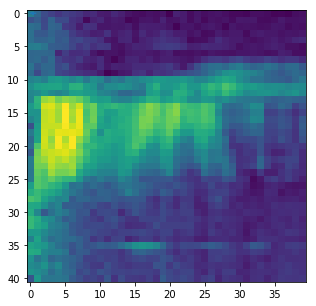

In [18]:
interesting = mat['train_samples'][24,0]
audio = [item for sublist in interesting for item in sublist]
new_result = one_mfsc(audio, 20000, None, 41, 40).T #Hop size is unnecessary but kept for security.
sample_rate=20000


#testing = 1
plt.figure(figsize=(5,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(new_result, aspect='auto', origin='lower');
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

In [31]:
print(len(results[0][0]))

41
